# JV Analysis


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.ticker as ticker

# Set the path to the foldercontaining text files
folder_path = "C:\\Users\\w16025698\\OneDrive - Northumbria University - Production Azure AD\\PhD\\Characterisation\\JV\\230221J_JV"

file_name = "A4.txt"
file_title = file_name.replace('.txt', '')

# Read the data from the text file, skipping the first 12 lines
data = np.loadtxt(os.path.join(folder_path, file_name), skiprows=12)

# Extract the voltage and current data from the columns
V = data[:,0]
I = data[:,1] 

mV = V * 1000
mA = I * 1000

# Cell area cm2 and incident power density mW/cm2
cell_area = 0.16
incident_power_density = 100
        
# Current density mA/cm2
current_density = mA / cell_area

## Definitions

In [3]:
# Interpolate more data points
jv_interp = interp1d(mV, current_density, kind='linear', bounds_error=False, fill_value="extrapolate")
mV_i = np.linspace(-100, 600, 1000)
current_density_i = jv_interp(mV_i)

# Calculate the power density from the voltage and current density data : units mW/cm2
power_density = current_density_i * mV_i / 1000

# Indices of max power point
max_power_index = np.argmax(power_density)

## Value Determination

In [4]:
# Create a data frame to store device data
df = pd.DataFrame(columns=['file_name', 'efficiency', 'open_circuit_voltage', 'short_circuit_current', 'fill_factor', 'Rs', 'Rsh'])

# Calculate the open circuit voltage, short circuit current, fill factor and efficiency

short_circuit_index = np.where(np.diff(np.sign(mV_i)))
short_circuit_current = current_density_i[short_circuit_index]
open_circuit_index = np.where(np.diff(np.sign(current_density_i)))
open_circuit_voltage = mV_i[open_circuit_index]
fill_factor = (mV_i[max_power_index]*current_density_i[max_power_index])/(open_circuit_voltage[0] *short_circuit_current[0])
efficiency = short_circuit_current[0] * open_circuit_voltage[0] * fill_factor / incident_power_density /10

# gradient calculation
grad = np.gradient(current_density_i, mV_i)
Voc_slope = grad[open_circuit_index]
Rs = 1/ np.abs(Voc_slope)
Jsc_slope = grad[0]
Rsh = 1/np.abs(Jsc_slope)

df = df.append({'file_name': file_name, 'efficiency': efficiency, 'open_circuit_voltage': open_circuit_voltage[0], 'short_circuit_current': short_circuit_current[0], 'fill_factor': fill_factor, 'Rs': Rs[0], 'Rsh': Rsh}, ignore_index=True)

## Values

In [5]:
print("Maximum power density:", "{:.2f}".format(power_density[max_power_index]), "mWcm2")
print("Short circuit current density:", "{:.2f}".format(short_circuit_current[0]), "mAcm2")
print("Open circuit voltage:", "{:.2f}".format(open_circuit_voltage[0]), "mV")
print("Fill Factor:","{:.2f}".format(fill_factor))
print("Efficiency:", "{:.2f}".format(efficiency), "%")
print("Series Resistance:","{:.2f}".format(Rs[0]), 'Ohms')
print("Shunt Resistance:","{:.2f}".format(Rsh), 'Ohms')

display(df)

Maximum power density: 5.06 mWcm2
Short circuit current density: 25.21 mAcm2
Open circuit voltage: 414.31 mV
Fill Factor: 0.48
Efficiency: 5.06 %
Series Resistance: 4.55 Ohms
Shunt Resistance: 304.32 Ohms


,file_name,efficiency,open_circuit_voltage,short_circuit_current,fill_factor,Rs,Rsh
0,A4.txt,5.058299,414.314314,25.214685,0.484196,4.552747,304.322939


##  JV & power denisty plot

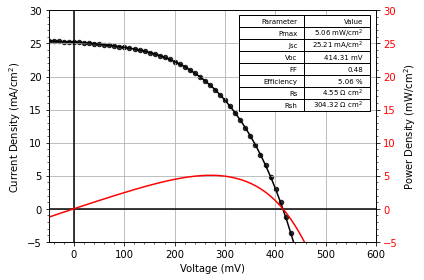

In [6]:
# Plot the JV curve and the power curve on the same plot
fig, ax1 = plt.subplots()

# Plot the JV curve on the left axis
ax1.set_xlabel("Voltage (mV)")
ax1.set_ylabel("Current Density (mA/cm$^2$)")
ax1.scatter(mV, current_density, c='k', alpha=0.8, marker='o', s=20)
ax1.plot(mV_i, current_density_i, color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.set_ylim(-5, 30)
ax1.set_xlim(-50, 600)
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(20))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.grid()
plt.axhline(0, color='k')
plt.axvline(0, color='k')

# Plot Voc and Jsc
#plt.plot(open_circuit_voltage[0], 0 ,'ro')
#plt.plot(0, short_circuit_current[0], 'ro')

# Create a second axis for the power curve on the right
ax2 = ax1.twinx()
ax2.set_ylabel("Power Density (mW/cm$^2$)")
#ax2.scatter(mV_i, power_density, c='r', alpha=0.8, marker='o', s=20)
ax2.plot(mV_i, power_density, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(1))
ax2.set_ylim(-5, 30)
#ax2.grid()
#plt.plot(mV_i[max_power_index],power_density[max_power_index],'ko')
plt.tight_layout()

# Add a table with parameters
table_data = [
    ['Parameter', 'Value'],
    ['Pmax', "{:.2f}".format(power_density[max_power_index]) + ' mW/cm$^2$'],
    ['Jsc', "{:.2f}".format(short_circuit_current[0]) + ' mA/cm$^2$'],
    ['Voc', "{:.2f}".format(open_circuit_voltage[0]) + ' mV'],
    ['FF', "{:.2f}".format(fill_factor)],
    ['Efficiency', "{:.2f}".format(efficiency) + ' %'],
    ['Rs', "{:.2f}".format(Rs[0]) + ' \u03A9 cm$^2$'],
    ['Rsh', "{:.2f}".format(Rsh) + ' \u03A9 cm$^2$'],
]

table = plt.table(cellText=table_data, colWidths=[0.4, 0.4], loc='upper right')
table.auto_set_font_size(False)
table.set_fontsize(7)
table.scale(0.5, 1.0)

# Add a title and show the plot
#plt.title(file_title + '_JV')

# Figure save settings
save_dir = os.path.join(folder_path, 'JV plots')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, file_title + '.png'), dpi=300)